## Extension of the racial disparities project: comparison between red and blue states in 2016. Is there a link between racial bias in the police and the major political orientation of the region?

### 1. Introduction
Peut etre ajouter une petite intro

In [1]:
#IMPORTING LIBRARIES
#Tools:
import pandas as pd
import numpy as np

#For data loading:
import os
import pickle

#For plotting:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

#Statistics:
import scipy.stats as stats
import scipy as sp
from statsmodels.stats import diagnostic
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

#Others:
import warnings

In [2]:
#Removing warnings
warnings.filterwarnings('ignore')

In [3]:
#DATASETS IMPORTATION:
df = pd.read_csv('data/opp-stops_state.csv')
counties =  pd.read_csv('2016_US_County_Level_Presidential_Results.csv')

#Dropping Nan values:
df = df.dropna()
counties = counties.dropna()

##Dropping useless data for our analysis
df.drop(columns = ['city', 'geography'], inplace = True)

We now check which states have complete information on hit rate and threshold in order to decide which states we can select for analysis.

In [4]:
#So, we have information on the hit rate and threshold for these states:
print("States with information on hit rate and threshold: ",(df.groupby('state').nunique()).index)

States with information on hit rate and threshold:  Index(['CT', 'IL', 'NC', 'RI', 'SC', 'TX', 'WA', 'WI'], dtype='object', name='state')


We compared with the results of the 2016 US presidential elections on the website https://www.nytimes.com/elections/2016/results/president and selected from these states the ones that were categorically blue (Democrat) or red (Republican).

- Our selected red states are: South Carolina and Texas (SC, TX)
- Our selected blue states are: Illinois, Connecticut, Rhode Island, Washington (IL, CT, RI, WA)

The others do not have a sufficiently marked percentage far away from the 50% (NC), or are swing states that tend to switch parties during elections (WI). 

### 2. Quick data verification:
We now verify that the number of arrests was large enough to have significant results in both groups of states (blue and red). 
We perform the same test on the number of searches, as we compare the hit rates during police stops which involved search specifically.

This is done after first sorting states and counties into the blue and red ones.

In [27]:
#To sort the states between red and blue:
##Definition of array with the names of red and blue states

red_states = ['SC', 'TX']
blue_states  = ['IL', 'CT', 'RI', 'WA']

##Function that returns a string containing the color of the state, according to its name and thanks to the arrays defined above
def what_color (name, blue_, red_):
    """input: name of the state (string) and the arrays with the red and blue states
    output: the color of the state (string)"""
    if any(s == name for s in blue_):
        return 'blue'
    elif any(s == name for s in red_):
        return 'red'
    else:
        return 'none'

##Loop function on all the state of the givcen dataframe to find the color of each one of them
def sort_array_of_state(dataframe, blue_, red_):
    """input: the dataframe to sort, the arrays with the list of the blue and red states
    output: an array with the list of the colors of the states in the same order"""
    colors = []
    for state in dataframe['state']:
        colors.append(what_color(state, blue_, red_))
    return colors
    
##Application of the function on our dataframe of interest
df['party'] = sort_array_of_state(df, blue_states, red_states)
df

,state,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,party,nb_search,state_percent
418,CT,Fairfield County,white,0.013487,0.065458,0.356108,0.223550,17189.760000,160113.120000,blue,231.840000,4.6
419,CT,Fairfield County,black,0.029384,0.073116,0.315113,0.171864,5080.320000,25650.720000,blue,149.280000,4.6
420,CT,Fairfield County,hispanic,0.020520,0.039236,0.257426,0.198470,4725.120000,21654.720000,blue,96.960000,4.6
421,CT,Hartford County,white,0.012005,0.065458,0.319820,0.238114,17752.800000,160113.120000,blue,213.120000,4.6
422,CT,Hartford County,black,0.036567,0.073116,0.303398,0.155822,5408.160000,25650.720000,blue,197.760000,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...
3927,WI,Kenosha County,black,0.051806,0.032153,0.337143,0.168363,827.265306,11545.959184,none,42.857143,0.0
3928,WI,Kenosha County,hispanic,0.034705,0.018971,0.279070,0.170613,606.857143,7220.326531,none,21.061224,0.0
3996,WI,Rock County,white,0.024457,0.035205,0.373786,0.227040,4125.551020,165997.224490,none,100.897959,0.0
3997,WI,Rock County,black,0.094879,0.032153,0.405858,0.119259,616.897959,11545.959184,none,58.530612,0.0


Now that we specified the color of the state, we can proceed with the data verification.

In [6]:
#Data verification:
##Definition of the number of search per year in a county, defined by the number of stops per year multiplied by the search rate.
df['nb_search'] = df['search_rate']*df['stops_per_year']

##To compare them, creation of blue and red dataframe:
blue = df[df['party'].str.contains('blue')]
red = df[df['party'].str.contains('red')]

##Verification
nb_search_red = red['nb_search'].sum()
nb_stops_red = red['stops_per_year'].sum()
nb_search_blue = blue['nb_search'].sum()
nb_stops_blue = blue['stops_per_year'].sum()

print("For red states : number of stops per year: ", nb_stops_red, " and number of searches per year : ", nb_search_red)
print("")
print("For red states : number of stops per year: ", nb_stops_blue, " and number of searches per year : ", nb_search_blue)
blue

For red states : number of stops per year:  2104964.397693118  and number of searches per year :  47958.64340845877

For red states : number of stops per year:  1071249.6266666665  and number of searches per year :  29642.008985507244


,state,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,party,nb_search
418,CT,Fairfield County,white,0.013487,0.065458,0.356108,0.223550,17189.760000,160113.120000,blue,231.840000
419,CT,Fairfield County,black,0.029384,0.073116,0.315113,0.171864,5080.320000,25650.720000,blue,149.280000
420,CT,Fairfield County,hispanic,0.020520,0.039236,0.257426,0.198470,4725.120000,21654.720000,blue,96.960000
421,CT,Hartford County,white,0.012005,0.065458,0.319820,0.238114,17752.800000,160113.120000,blue,213.120000
422,CT,Hartford County,black,0.036567,0.073116,0.303398,0.155822,5408.160000,25650.720000,blue,197.760000
...,...,...,...,...,...,...,...,...,...,...,...
3830,WA,Whatcom County,black,0.040621,0.170683,0.147059,0.081542,436.695652,42944.347826,blue,17.739130
3831,WA,Whatcom County,hispanic,0.049693,0.094922,0.084211,0.058302,997.434783,83731.565217,blue,49.565217
3835,WA,Yakima County,white,0.014689,0.127457,0.168184,0.124030,16578.521739,637472.869565,blue,243.521739
3836,WA,Yakima County,black,0.028600,0.170683,0.226087,0.109568,524.478261,42944.347826,blue,15.000000


We can see that the numbers of searches and stops are very large, so we consider our sample to be sufficiently large to continue our research process.

### 3. PRESENTATION DES DONNEES - trucs que Louis a fait LOUIS TU POURRAS CHECKER QUE C'EST BIEN 
ATTENTION faut voir si nos dataframes sont utilisables dans le code de l'autre par exemple ici en dessous j'ai remplacé ton "df_blue" de ton code par blue, celui que j'ai créé au dessus. je sais pas si ça donne la même chose mais normalement oui?

In [7]:
#Creation of dataframe easier to manipulate for visualization of the data
df_blue_pivot = blue.pivot_table(index = ['subgeography','state'], columns = 'subject_race')
df_red_pivot = red.pivot_table(index = ['subgeography','state'], columns = 'subject_race')

### Visualizing hit rates and threshold


In [8]:
# function that takes dataframe original blue or red dataframe as input and as output a dataframe with only data for hispanic and black
# also adds normalized hit rate column and normalized threshold column
def add_normalized_rates(df):
    df_white = df[df.subject_race == 'white'].reset_index(drop = True)
    df_black = df[df.subject_race == 'black'].reset_index(drop = True)
    df_hispanic = df[df.subject_race == 'hispanic'].reset_index(drop = True)
    df_black['hit_rate_normalized'] = (df_black.hit_rate / df_white.hit_rate)
    df_hispanic['hit_rate_normalized'] = (df_hispanic.hit_rate / df_white.hit_rate)
    df_black['threshold_normalized'] = (df_black.inferred_threshold / df_white.inferred_threshold)
    df_hispanic['threshold_normalized'] = (df_hispanic.inferred_threshold / df_white.inferred_threshold)
    return pd.concat([df_hispanic,df_black])

In [9]:
# function to plot the bar plots nicely
def plot_bar(method, data, params):
    ylim, ax = params
    sns.barplot(x = "state", y = method, hue = "subject_race", data = data, ax = ax)
    ax.set_ylim(ylim)
    ax.set_xlim([-0.5,5.5])
    ax.axhline(y=1, ls = (1, (10,5)), color = 'black', lw = 0.7)
    x = np.arange(-0.5, 3.5, 0.01)
    ax.fill_between(x, ylim[0],ylim[1], color = "#5DADE2", alpha =0.5)    
    x = np.arange(3.5, 6, 0.01)
    ax.fill_between(x, ylim[0],ylim[1], color = "#E74C3C", alpha =0.5)

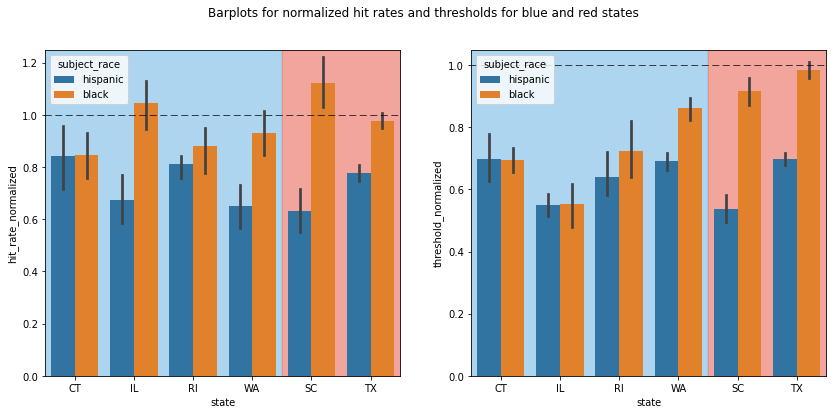

In [10]:
# add normalized rates for blue and red dataframes 
blue_normalized = add_normalized_rates(blue)
red_normalized = add_normalized_rates(red)

# put into one data frame so plot all in one
data = pd.concat([blue_normalized,red_normalized])

# prepare arguments to plotting function
methods = ["hit_rate_normalized", "threshold_normalized"]
ylim = [[0,1.25], [0,1.05]]

fig, axs = plt.subplots(1,2,figsize=(14,6))
plt.suptitle("Barplots for normalized hit rates and thresholds for blue and red states")
for method in range(2):
    params = [ylim[method],axs[method]]
    plot_bar(methods[method],data, params)

In [11]:
red_normalized.head()


,state,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,party,nb_search,hit_rate_normalized,threshold_normalized
0,SC,Aiken County,hispanic,0.097844,0.113592,0.171032,0.054565,1188.000000,30374.149254,red,116.238806,0.524481,0.401955
1,SC,Anderson County,hispanic,0.051656,0.113592,0.173913,0.099665,1275.940299,30374.149254,red,65.910448,0.626176,0.603384
2,SC,Beaufort County,hispanic,0.099145,0.113592,0.107190,0.054471,1381.970149,30374.149254,red,137.014925,0.603032,0.453513
3,SC,Berkeley County,hispanic,0.078427,0.113592,0.096692,0.066476,897.492537,30374.149254,red,70.388060,0.459339,0.583772
4,SC,Calhoun County,hispanic,0.095064,0.113592,0.096154,0.067311,97.970149,30374.149254,red,9.313433,0.212202,0.301201


## Rajouter les trucs de Louis j'ai commencé mais j'ai eu la flemme

#### Another data visualization: plotting hit rates and threshold like in figure 3.a of the paper, for red and blue states respectively.

In [12]:
#Useful dataframes to do that:
##red statess
black_red = red[red['subject_race'].str.contains('black')]
white_red = red[red['subject_race'].str.contains('white')]
hisp_red  = red[red['subject_race'].str.contains('hispanic')]

hit_black_red = black_red[['subgeography', 'hit_rate', 'nb_search']]
white_red = white_red.set_index(hit_black_red.index)
hit_black_red['hit_white'] = white_red['hit_rate']

thres_black_red = black_red[['subgeography', 'inferred_threshold', 'nb_search']]
thres_black_red['thres_white'] = white_red['inferred_threshold']

hit_hisp_red = hisp_red[['subgeography', 'hit_rate', 'nb_search']]
white_red = white_red.set_index(hit_hisp_red.index)
hit_hisp_red['hit_white'] = white_red['hit_rate']

thres_hisp_red = hisp_red[['subgeography', 'inferred_threshold', 'nb_search']]
thres_hisp_red['thres_white'] = white_red['inferred_threshold']

hit_nc_red = pd.concat([hit_black_red, hit_hisp_red])
thres_nc_red = pd.concat([thres_black_red, thres_hisp_red])

##blue states
black_blue = blue[blue['subject_race'].str.contains('black')]
white_blue = blue[blue['subject_race'].str.contains('white')]
hisp_blue  = blue[blue['subject_race'].str.contains('hispanic')]

hit_black_blue = black_blue[['subgeography', 'hit_rate', 'nb_search']]
white_blue = white_blue.set_index(hit_black_blue.index)
hit_black_blue['hit_white'] = white_blue['hit_rate']

thres_black_blue = black_blue[['subgeography', 'inferred_threshold', 'nb_search']]
thres_black_blue['thres_white'] = white_blue['inferred_threshold']

hit_hisp_blue = hisp_blue[['subgeography', 'hit_rate', 'nb_search']]
white_blue = white_blue.set_index(hit_hisp_blue.index)
hit_hisp_blue['hit_white'] = white_blue['hit_rate']

thres_hisp_blue = hisp_blue[['subgeography', 'inferred_threshold', 'nb_search']]
thres_hisp_blue['thres_white'] = white_blue['inferred_threshold']

hit_nc_blue = pd.concat([hit_black_blue, hit_hisp_blue])
thres_nc_blue = pd.concat([thres_black_blue, thres_hisp_blue])
thres_nc_blue.head()

,subgeography,inferred_threshold,nb_search,thres_white
419,Fairfield County,0.171864,149.28,0.223550
422,Hartford County,0.155822,197.76,0.238114
425,Litchfield County,0.184323,31.50,0.262494
431,New Haven County,0.166497,170.88,0.233488
434,New London County,0.172387,96.96,0.225318


In [28]:
#This function plots the hit rate or threshold rate of white people vs black or hispanic people. It takes as input
#the axis for the figure, the color of the state, which rate is being represented, the title of the graphe, and the
#specific dataframes necessary for the graph.
def plot_rates(ax,color,rate,title,df_white,df_black,df_hisp):
    if color == 'blue':
        eg1 = '#7C6FFB'
        eg2 = '#6FCBFB'
        
    else:
        eg1 = '#FF315F'
        eg2 = '#FF6331'
  
    s1 = df_black['nb_search'].values
    s2 = df_hisp['nb_search'].values
    ax.scatter(df_white[rate]*100, df_black[rate]*100,  s = s1, facecolors='none', edgecolors=eg1, label = 'black')
    ax.scatter(df_white[rate]*100, df_hisp[rate]*100,  s = s2, facecolors='none', edgecolors=eg2, label = 'hispanic')
    ax.plot([0,1],[0,1], linestyle = '--', linewidth = 1, color='black',transform=ax.transAxes)
    
    ax.set(xlabel=None, ylabel='Minority hit rate (%)')
    lgnd = ax.legend()
    
    div = make_axes_locatable(ax)
    ax = div.append_axes("top", size="10%", pad=0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('gainsboro')
    at = AnchoredText(title, loc=10, prop=dict(backgroundcolor='gainsboro', size=10, color='black'))
    ax.add_artist(at)
    
    fig.text(0.5,0, 'White threshold (%)')
    
    lgnd.legendHandles[0].set_sizes([65])
    lgnd.legendHandles[1].set_sizes([65])

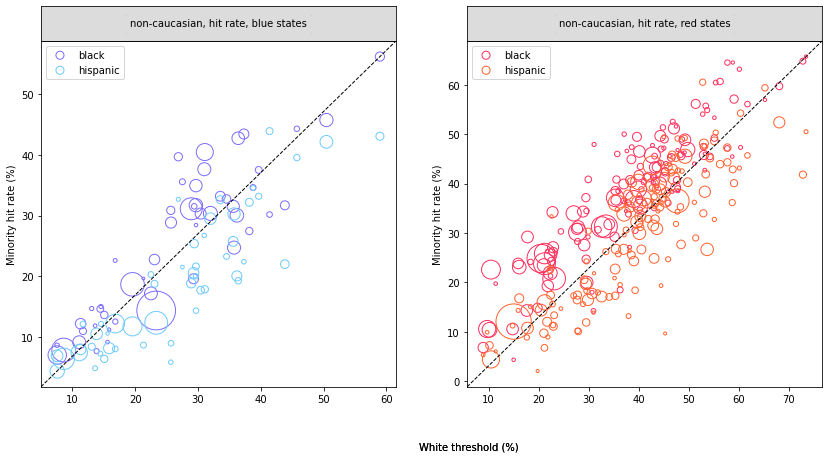

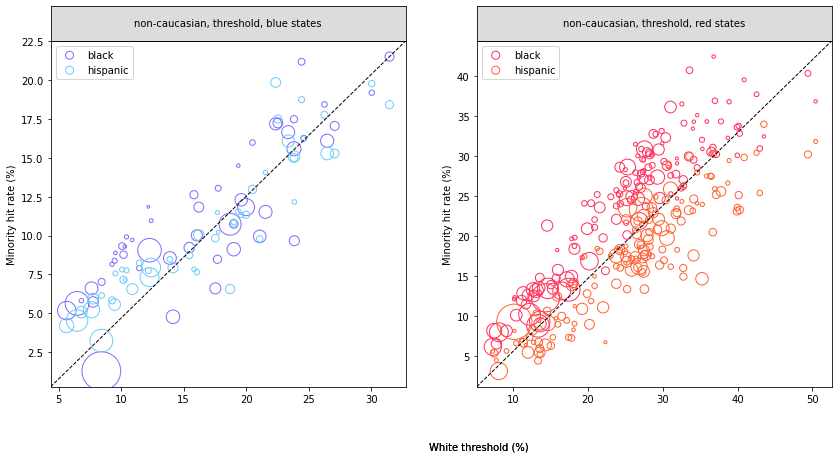

In [29]:
#We now use the function above to plot the data
fig, ax = plt.subplots(1,2,figsize=(14,7))
plot_rates(ax[0],'blue','hit_rate',"non-caucasian, hit rate, blue states",white_blue,black_blue,hisp_blue)
plot_rates(ax[1],'red','hit_rate',"non-caucasian, hit rate, red states",white_red,black_red,hisp_red)

fig, ax = plt.subplots(1,2,figsize=(14,7))
plot_rates(ax[0],'blue','inferred_threshold',"non-caucasian, threshold, blue states",white_blue,black_blue,hisp_blue)
plot_rates(ax[1],'red','inferred_threshold',"non-caucasian, threshold, red states",white_red,black_red,hisp_red)

#### Data observation
Visually, one can see that the hit rates and thresholds for non-Caucasian minorities are generally lower than their equivalent for white drivers. Note that we have grouped hispanic and black drivers together as non-Caucasian and put them in the same plot.

### 4. Quantified alternative for comparison and example
In order to quantify this information and compare it with more reliable statistical tools than a simple visual comparison, we have computed a new value: the minority/white ratio. This makes it possible to compare these values across the counties and for the different minorities studied.

For example, for the threshold for Hispanic drivers in the red states, the value will be the threshold for Hispanic drivers divided by the threshold for white drivers.
We will calculate a weighted average within the red and blue states respectively. We weight the average by the number of search rates, multiplying the value of the data (hit rate or threshold) by the number of search rates in the county in question, before calculating the average over all searches in all counties. 
Once we have obtained an average ratio for all the red and blue counties respectively, and for all the concepts studied (hit rate and threshold), we will be able to compare these averages.

In [30]:
def ratio(df,rate,rate_white):
    df['ratio'] = df[rate]/df[rate_white]

In [ ]:
def pondering(df_p,df)
    df_p = np.repeat

In [16]:
#Computation of the ratio
for df in 
### The hit rate ratio between black drivers and white drivers in RED states to be compared with BLUE states
hit_black_red['ratio'] = ratio(hit_black_red,'hit_rate','hit_white')
hit_black_blue['ratio'] = ratio(hit_black_blue,'hit_rate','hit_white')

### The hit rate ratio between hispanic drivers and white drivers in RED states to be compared with BLUE states
hit_hisp_red['ratio'] = ratio(hit_hisp_red,'hit_rate','hit_white')
hit_hisp_blue['ratio'] = ratio(hit_hisp_blue,'hit_rate','hit_white')

### The threshold ratio between black drivers and white drivers in RED states to be compared with BLUE states
thres_black_red['ratio'] = ratio(thres_black_red,'inferred_threshold','thres_white')
thres_black_blue['ratio'] = ratio(thres_black_blue,'inferred_threshold','thres_white')

### also, the thresholds ratio between hispanic drivers and white drivers in RED states
thres_hisp_red['ratio'] = ratio(thres_hisp_red,'inferred_threshold','thres_white')
### to be compared with this : the thresholds ratio between hispanic drivers and white drivers in BLUE states
thres_hisp_blue['ratio'] = ratio(thres_hisp_blue,'inferred_threshold','thres_white')

# For statistical reliability in the mean estimation we ponder the data by the number of searches per year in each county:

hit_hisp_blue_p    = np.repeat(hit_hisp_blue.ratio,hit_hisp_blue.nb_search)
hit_hisp_red_p     = np.repeat(hit_hisp_red.ratio,hit_hisp_red.nb_search)
hit_black_red_p    = np.repeat(hit_black_red.ratio,hit_black_red.nb_search)
hit_black_blue_p   = np.repeat(hit_black_blue.ratio,hit_black_blue.nb_search)

thres_hisp_blue_p  = np.repeat(thres_hisp_blue.ratio,thres_hisp_blue.nb_search)
thres_hisp_red_p   = np.repeat(thres_hisp_red.ratio,thres_hisp_red.nb_search)
thres_black_red_p  = np.repeat(thres_black_red.ratio,thres_black_red.nb_search)
thres_black_blue_p = np.repeat(thres_black_blue.ratio,thres_black_blue.nb_search)


#### Evaluation of the distribution of the ratios and accordingly, statistical test to test the difference of mean between samples.

In [17]:
# Test of the normality of the distribution to choose an adapted statistical test
## the p value given tests the null hypothesis stating that the distribution is normal.

print("distribution of hit rates for hispanic drivers in blue state, p value :", (diagnostic.kstest_normal(hit_hisp_blue_p, dist = 'norm'))[1])
print("distribution of hit rates for hispanic drivers in red state, p value :", (diagnostic.kstest_normal(hit_hisp_red_p, dist = 'norm'))[1])
print("distribution of hit rates for black drivers in blue state, p value :", (diagnostic.kstest_normal(hit_black_blue_p, dist = 'norm'))[1])
print("distribution of hit rates for black drivers in red state, p value :", (diagnostic.kstest_normal(hit_black_red_p, dist = 'norm'))[1])

print("distribution of threshold for hispanic drivers in blue state, p value :", (diagnostic.kstest_normal(thres_hisp_blue_p, dist = 'norm'))[1])
print("distribution of threshold for hispanic drivers in red state, p value :", (diagnostic.kstest_normal(thres_hisp_red_p, dist = 'norm'))[1])
print("distribution of threshold for black drivers in blue state, p value :", (diagnostic.kstest_normal(thres_black_blue_p, dist = 'norm'))[1])
print("distribution of threshold for black drivers in red state, p value :", (diagnostic.kstest_normal(thres_black_red_p, dist = 'norm'))[1])

distribution of hit rates for hispanic drivers in blue state, p value : 1.9940164616132965e-136
distribution of hit rates for hispanic drivers in red state, p value : 9.243780275185795e-308
distribution of hit rates for black drivers in blue state, p value : 0.0
distribution of hit rates for black drivers in red state, p value : 0.0
distribution of threshold for hispanic drivers in blue state, p value : 0.0
distribution of threshold for hispanic drivers in red state, p value : 7.968900285255387e-199
distribution of threshold for black drivers in blue state, p value : 0.0
distribution of threshold for black drivers in red state, p value : 0.0


We can see that in each case the null hypothesis is rejected, we cannot consider these distribution as normal. Therefore we use the Mann-Whitneyu test to compare their mean. This test tests the null hypothesis stating that the mean of sample from blue states are not lower than in red states (not significantly lower). The mean reflects the ratio between the hit rate of a minority vs. the hit rate for white people. The lower it is, the closer the hit rate for minorities is close to the one for white people, which means less bias from the police during arrestation and searches.

In [18]:
diagnostic.kstest_normal(hit_hisp_red['ratio'], dist = 'norm')
print("p value for null hypothesis stating that the means are not significantly different")
print("for mean hit rates ratio (hispanic vs white) for drivers in blue and red states : ", (stats.mannwhitneyu(hit_hisp_blue_p, hit_hisp_red_p, alternative='less'))[1])
print("for mean hit rates ratio (black vs white) for drivers in blue and red states : ", (stats.mannwhitneyu(hit_black_blue_p, hit_black_blue_p, alternative='less'))[1])
print("for mean threshold ratio (hispanic vs white) for drivers in blue and red states : ", (stats.mannwhitneyu(thres_hisp_blue_p, thres_hisp_red_p, alternative='less'))[1])
print("for mean threshold ratio (black vs white) for drivers in blue and red states : ", (stats.mannwhitneyu(thres_black_blue_p, thres_black_red_p, alternative='less'))[1])

p value for null hypothesis stating that the means are not significantly different
for mean hit rates ratio (hispanic vs white) for drivers in blue and red states :  1.6565169548004745e-235
for mean hit rates ratio (black vs white) for drivers in blue and red states :  0.50000078556977
for mean threshold ratio (hispanic vs white) for drivers in blue and red states :  5.0753664611380306e-207
for mean threshold ratio (black vs white) for drivers in blue and red states :  0.0


#### The test result states that there is significant difference between red and blue states when observing:
- hit rates for hispanic drivers
- threshold for hispanic drivers
- threshold for black drivers

#### Prediction model
To investigate further, we will try to estimate the ratio mentioned above from the other parameters of the dataframe. In this way, we will be able to observe whether the trained model gives importance to political preference in the county in question. For this, we have added to our data the percentage obtained by the majority party. We created an index (called purcent in the dataframe) which is the difference between the party score and the majority (50%), which we multiplied by -1 if the chosen party is the republican party. This gives for example for Texas where the republican party won at 52.2% an index of -2.2. Similarly, the state of Illinois where the Democrats won at 55.2% will have an index of 5.2.It is important that, for the moment, we evaluate political trends at the state level: state colour and state percentage.

In [19]:
# Adding the scores for each state:
illinois = 5.2
ct = 4.6
ri = 4.4
sc = -4.9
texas = -2.2
results = [illinois, ct, ri, sc, texas]

def what_percent (name, results):
    [illinois, ct, ri, sc, texas] =  results
    if (name == 'IL'):
        return illinois
    if (name == 'CT'):
        return ct
    if (name == 'RI'):
        return ri
    if (name == 'SC'):
        return sc
    if (name == 'TX'):
        return texas
    else:
        return 0.0


def find_state_percent(df, results):
    purcentage = []
    for state in df['state']:
        purcentage.append(what_percent(state, results))
    return purcentage

df['state_percent'] = find_state_percent(df, results)


In [20]:
#question: est-ce qu'on doit multiplier les lignes par le nombre de search comme pour la mean ?

In [21]:
df.head()

,state,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,party,nb_search,state_percent
418,CT,Fairfield County,white,0.013487,0.065458,0.356108,0.223550,17189.76,160113.12,blue,231.84,4.6
419,CT,Fairfield County,black,0.029384,0.073116,0.315113,0.171864,5080.32,25650.72,blue,149.28,4.6
420,CT,Fairfield County,hispanic,0.020520,0.039236,0.257426,0.198470,4725.12,21654.72,blue,96.96,4.6
421,CT,Hartford County,white,0.012005,0.065458,0.319820,0.238114,17752.80,160113.12,blue,213.12,4.6
422,CT,Hartford County,black,0.036567,0.073116,0.303398,0.155822,5408.16,25650.72,blue,197.76,4.6


In [22]:
mod = smf.logit(formula='hit_rate ~ state_percent + party + subject_race', data=df)
res = mod.fit()
print(res.summary())

#papers_2020.reset_index(drop=True, inplace=True)

Optimization terminated successfully.
         Current function value: 0.524338
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               hit_rate   No. Observations:                  675
Model:                          Logit   Df Residuals:                      669
Method:                           MLE   Df Model:                            5
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  -1.144
Time:                        11:12:11   Log-Likelihood:                -353.93
converged:                       True   LL-Null:                       -165.08
Covariance Type:            nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.0345      0.351     -5.789      0.000      -2.723

## How to be even more accurate and precise: visualization, comparison and prediction at the county-level
As mentioned earlier, we have only looked at state-level political trends. If political trends and police bias are indeed linked, we need clear political outcomes, for example at the county level which would be more precise and give more accurate results. This is important because within the same state with a score that is not obvious (e.g. 52.2% red for Texas) there are counties with scores as high as 94.6% for Republicans in Roberts County or completely opposite, e.g. 65.8% for Democrats in Travis County.
We have therefore looked for data on the results at the county level and will use it to refine our study.
First, let's look at the hit rates and thersholds for white and Hispanic drivers in different counties in the state of Texas.

In [23]:
# Quick data verification of number of arrestations per year to have significant sample for both red and blue counties
##Verification

# FAIRE LA MEME CHOSE QUE AU DESSUS POUR LES ETATS, juste comparer le nombre d'arrestations dans tous les county bleus au nombre dans tous les county rouges pour vérifier que 
# ces nombres sont assez grands pour être statistiquement fiables
#code utilisé au dessus commenté, faudra le modifier mais en gros c'est ça qu'il faut faire

"""nb_search_red = red['nb_search'].sum()
nb_stops_red = red['stops_per_year'].sum()
nb_search_blue = blue['nb_search'].sum()
nb_stops_blue = blue['stops_per_year'].sum()

print("For red states : number of stops per year: ", nb_stops_red, " and number of searches per year : ", nb_search_red)
print("")
print("For red states : number of stops per year: ", nb_stops_blue, " and number of searches per year : ", nb_search_blue)"""

'nb_search_red = red[\'nb_search\'].sum()\nnb_stops_red = red[\'stops_per_year\'].sum()\nnb_search_blue = blue[\'nb_search\'].sum()\nnb_stops_blue = blue[\'stops_per_year\'].sum()\n\nprint("For red states : number of stops per year: ", nb_stops_red, " and number of searches per year : ", nb_search_red)\nprint("")\nprint("For red states : number of stops per year: ", nb_stops_blue, " and number of searches per year : ", nb_search_blue)'

In [24]:
tx = df.loc[df["state"] == "TX"]
counties['color'] = np.where(counties["per_dem"] > counties["per_gop"], "blue", "red")
counties = counties.loc[counties["state_abbr"] == "TX"]
tx = pd.merge(left=tx, right=counties, left_on='subgeography', right_on='county_name')
tx = tx.drop(['state','party','votes_dem','votes_gop','state_abbr','county_name','combined_fips','Unnamed: 0'],axis=1)

In [25]:
tx_white = tx.loc[tx["subject_race"]== 'white']
tx_white_b = tx_white.loc[tx_white['color'] == 'blue']
tx_white_r = tx_white.loc[tx_white['color'] == 'red']
tx_black = tx.loc[tx["subject_race"]== 'black']
tx_black_b = tx_black.loc[tx_black['color'] == 'blue']
tx_black_r = tx_black.loc[tx_black['color'] == 'red']
tx_hisp = tx.loc[tx["subject_race"]== 'hispanic']
tx_hisp_b = tx_hisp.loc[tx_hisp['color'] == 'blue']
tx_hisp_r = tx_hisp.loc[tx_hisp['color'] == 'red']

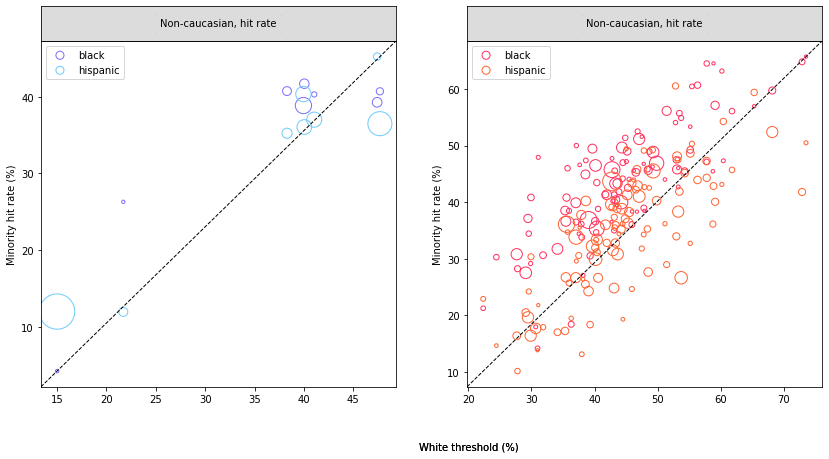

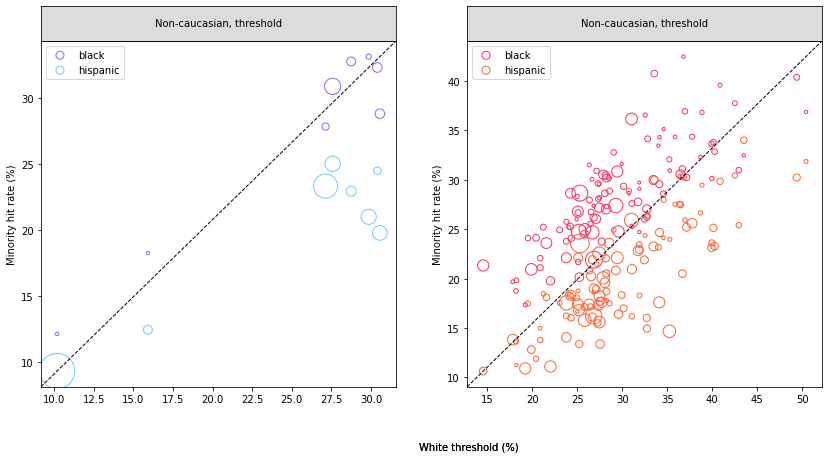

In [26]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
plot_rates(ax[0],'blue','hit_rate',"Non-caucasian, hit rate",tx_white_b,tx_black_b,tx_hisp_b)
plot_rates(ax[1],'red','hit_rate',"Non-caucasian, hit rate",tx_white_r,tx_black_r,tx_hisp_r)

fig, ax = plt.subplots(1,2,figsize=(14,7))
plot_rates(ax[0],'blue','inferred_threshold',"Non-caucasian, threshold",tx_white_b,tx_black_b,tx_hisp_b)
plot_rates(ax[1],'red','inferred_threshold',"Non-caucasian, threshold",tx_white_r,tx_black_r,tx_hisp_r)

#### Mean comparison for the red and blue counties

In [42]:
### à coder lol

#### Model prediction for the red and blue counties

In [43]:
### à coder lol